# 📸 NOTEBOOK 4 : EXPLORATION, FEATURES & CLUSTERING D'IMAGES

## Objectifs
1. **Analyse exploratoire approfondie** des images de produits e-commerce Flipkart
2. **Visualisation** d'échantillons d'images par catégorie
3. **Extraction de features visuelles** via Transfer Learning (CNNs pré-entraînés)
4. **Clustering non-supervisé** pour découvrir les regroupements naturels
5. **Évaluation** de la cohérence des clusters avec les vraies catégories

**Dataset** : 1050 images réparties en 7 catégories  
**Catégories** : Baby Care, Beauty and Personal Care, Computers, Home Decor & Festive Needs, Home Furnishing, Kitchen & Dining, Watches

## 1. IMPORTS ET CONFIGURATION

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import os
warnings.filterwarnings('ignore')

# Images
from PIL import Image
import cv2

# Deep Learning pour extraction de features
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.preprocessing import image as keras_image

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
from sklearn.manifold import TSNE

# Visualisation
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print(" UMAP non disponible, utilisation de t-SNE uniquement")

import plotly.express as px
import plotly.graph_objects as go

# Configuration matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

print(f"✅ TensorFlow version : {tf.__version__}")
print(f"✅ GPU disponible : {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"✅ UMAP disponible : {UMAP_AVAILABLE}")

✅ TensorFlow version : 2.20.0
✅ GPU disponible : False
✅ UMAP disponible : True


In [3]:
# Configuration des chemins
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "Data"
IMAGES_DIR = DATA_DIR / "images"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(exist_ok=True)

# Fichiers
METADATA_FILE = DATA_DIR / "data_images_corrected.csv"
FEATURES_OUTPUT = PROCESSED_DIR / "images_prepocessed.npy"

print(f" Répertoire images : {IMAGES_DIR}")
print(f" Métadonnées : {METADATA_FILE}")
print(f" Output features : {FEATURES_OUTPUT}")
print(f" Images existantes : {IMAGES_DIR.exists()}")

 Répertoire images : c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\Data\images
 Métadonnées : c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\Data\data_images_corrected.csv
 Output features : c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\Data\processed\images_prepocessed.npy
 Images existantes : True


## 2. CHARGEMENT DES MÉTADONNÉES

In [4]:
# Chargement du dataset
df = pd.read_csv(METADATA_FILE)

print(f"✅ Dataset chargé : {df.shape[0]} images, {df.shape[1]} colonnes")
print(f"\nColonnes disponibles :")
print(df.columns.tolist())
print(f"\nPremières lignes :")
display(df.head())

# Informations générales
print(f"\nInformations sur le dataset :")
print(df.info())

✅ Dataset chargé : 1050 images, 18 colonnes

Colonnes disponibles :
['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications', 'image_exists', 'image_path', 'main_category']

Premières lignes :


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,image_exists,image_path,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",True,d:\AS3\NLP\projet_nlp\data\images\55b85ea15a15...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",True,d:\AS3\NLP\projet_nlp\data\images\7b72c92c2f6c...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",True,d:\AS3\NLP\projet_nlp\data\images\64d5d4a25824...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",True,d:\AS3\NLP\projet_nlp\data\images\d4684dcdc759...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",True,d:\AS3\NLP\projet_nlp\data\images\6325b6870c54...,Home Furnishing



Informations sur le dataset :
<class 'pandas.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   str    
 1   crawl_timestamp          1050 non-null   str    
 2   product_url              1050 non-null   str    
 3   product_name             1050 non-null   str    
 4   product_category_tree    1050 non-null   str    
 5   pid                      1050 non-null   str    
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   str    
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   str    
 11  product_rating           1050 non-null   str    
 12  overall_rating           1050 non-null   str    
 13  brand                    712 non-null    str    
 14  prod

## 3. ANALYSE EXPLORATOIRE DES IMAGES

### 3.1 Distribution des catégories

📊 DISTRIBUTION DES CATÉGORIES
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

Nombre total de catégories : 7
Taille moyenne par catégorie : 150.0 images
Écart-type : 0.0 images


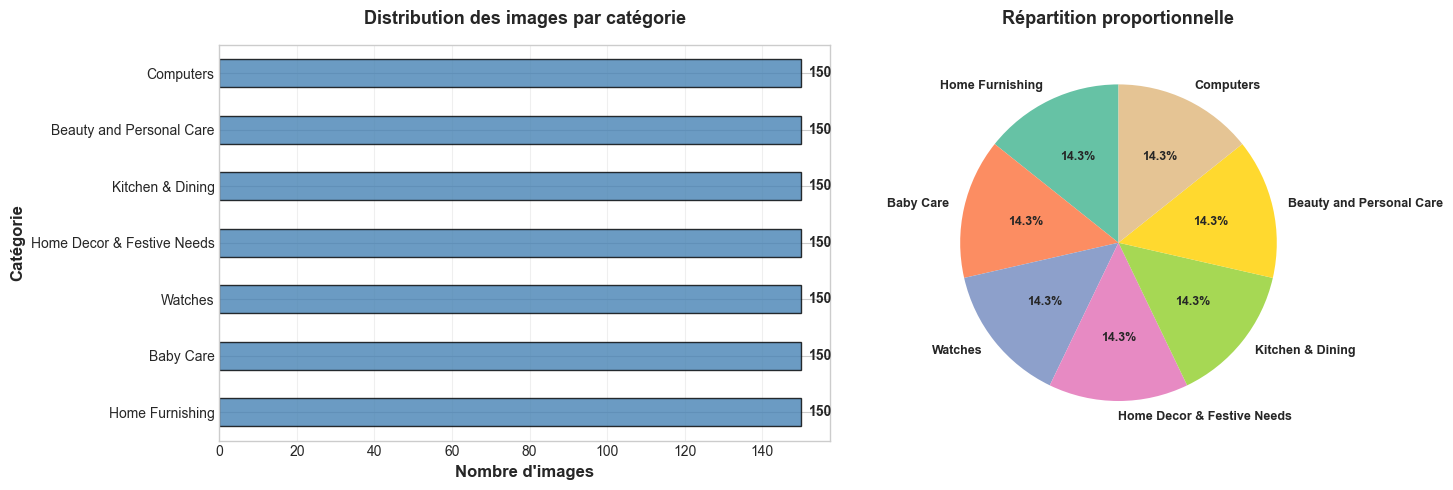


✅ Dataset parfaitement équilibré (variance < 10%)


In [5]:
# Distribution par catégorie
cat_counts = df['main_category'].value_counts()

print("="*70)
print("📊 DISTRIBUTION DES CATÉGORIES")
print("="*70)
print(cat_counts)
print(f"\nNombre total de catégories : {df['main_category'].nunique()}")
print(f"Taille moyenne par catégorie : {cat_counts.mean():.1f} images")
print(f"Écart-type : {cat_counts.std():.1f} images")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Barplot horizontal
cat_counts.sort_values().plot(kind='barh', ax=ax1, color='steelblue', edgecolor='black', alpha=0.8)
ax1.set_xlabel('Nombre d\'images', fontsize=12, fontweight='bold')
ax1.set_ylabel('Catégorie', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des images par catégorie', fontsize=13, fontweight='bold', pad=15)
ax1.grid(axis='x', alpha=0.3)

# Ajout des valeurs sur les barres
for i, (cat, count) in enumerate(cat_counts.sort_values().items()):
    ax1.text(count + 2, i, str(count), va='center', fontsize=10, fontweight='bold')

# Pie chart
colors = sns.color_palette('Set2', n_colors=len(cat_counts))
ax2.pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90, 
        colors=colors, textprops={'fontsize': 9, 'fontweight': 'bold'})
ax2.set_title('Répartition proportionnelle', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

# Test d'équilibre
if cat_counts.std() / cat_counts.mean() < 0.1:
    print("\n✅ Dataset parfaitement équilibré (variance < 10%)")
else:
    print(f"\n⚠️ Dataset légèrement déséquilibré (CV = {cat_counts.std()/cat_counts.mean()*100:.1f}%)")

### 3.2 Analyse des dimensions d'images

In [6]:
# Analyse dun échantillon de 200 images
sample_size = min(200, len(df))
sample_df = df.sample(sample_size, random_state=42)

print(f"🔍 Analyse des dimensions sur {sample_size} images...\n")

widths, heights, ratios, file_sizes = [], [], [], []

for img_path in sample_df['image']:
    full_path = IMAGES_DIR / img_path
    if full_path.exists():
        try:
            img = Image.open(full_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            ratios.append(w / h)
            file_sizes.append(full_path.stat().st_size / 1024)  # Ko
        except Exception as e:
            print(f" Erreur sur {img_path}: {e}")

# Statistiques
print("="*70)
print("📏 STATISTIQUES DES DIMENSIONS")
print("="*70)
print(f"\n📐 Largeur (pixels) :")
print(f"   Min  : {min(widths)}")
print(f"   Max  : {max(widths)}")
print(f"   Mean : {np.mean(widths):.0f}")
print(f"   Std  : {np.std(widths):.0f}")

print(f"\n📐 Hauteur (pixels) :")
print(f"   Min  : {min(heights)}")
print(f"   Max  : {max(heights)}")
print(f"   Mean : {np.mean(heights):.0f}")
print(f"   Std  : {np.std(heights):.0f}")

print(f"\n📐 Ratio Largeur/Hauteur :")
print(f"   Min  : {min(ratios):.2f}")
print(f"   Max  : {max(ratios):.2f}")
print(f"   Mean : {np.mean(ratios):.2f}")

print(f"\n💾 Taille de fichier (Ko) :")
print(f"   Min  : {min(file_sizes):.1f}")
print(f"   Max  : {max(file_sizes):.1f}")
print(f"   Mean : {np.mean(file_sizes):.1f}")

🔍 Analyse des dimensions sur 200 images...

📏 STATISTIQUES DES DIMENSIONS

📐 Largeur (pixels) :
   Min  : 185
   Max  : 8484
   Mean : 1236
   Std  : 1019

📐 Hauteur (pixels) :
   Min  : 160
   Max  : 11042
   Mean : 1335
   Std  : 1010

📐 Ratio Largeur/Hauteur :
   Min  : 0.24
   Max  : 3.42
   Mean : 1.01

💾 Taille de fichier (Ko) :
   Min  : 18.7
   Max  : 4246.9
   Mean : 382.5


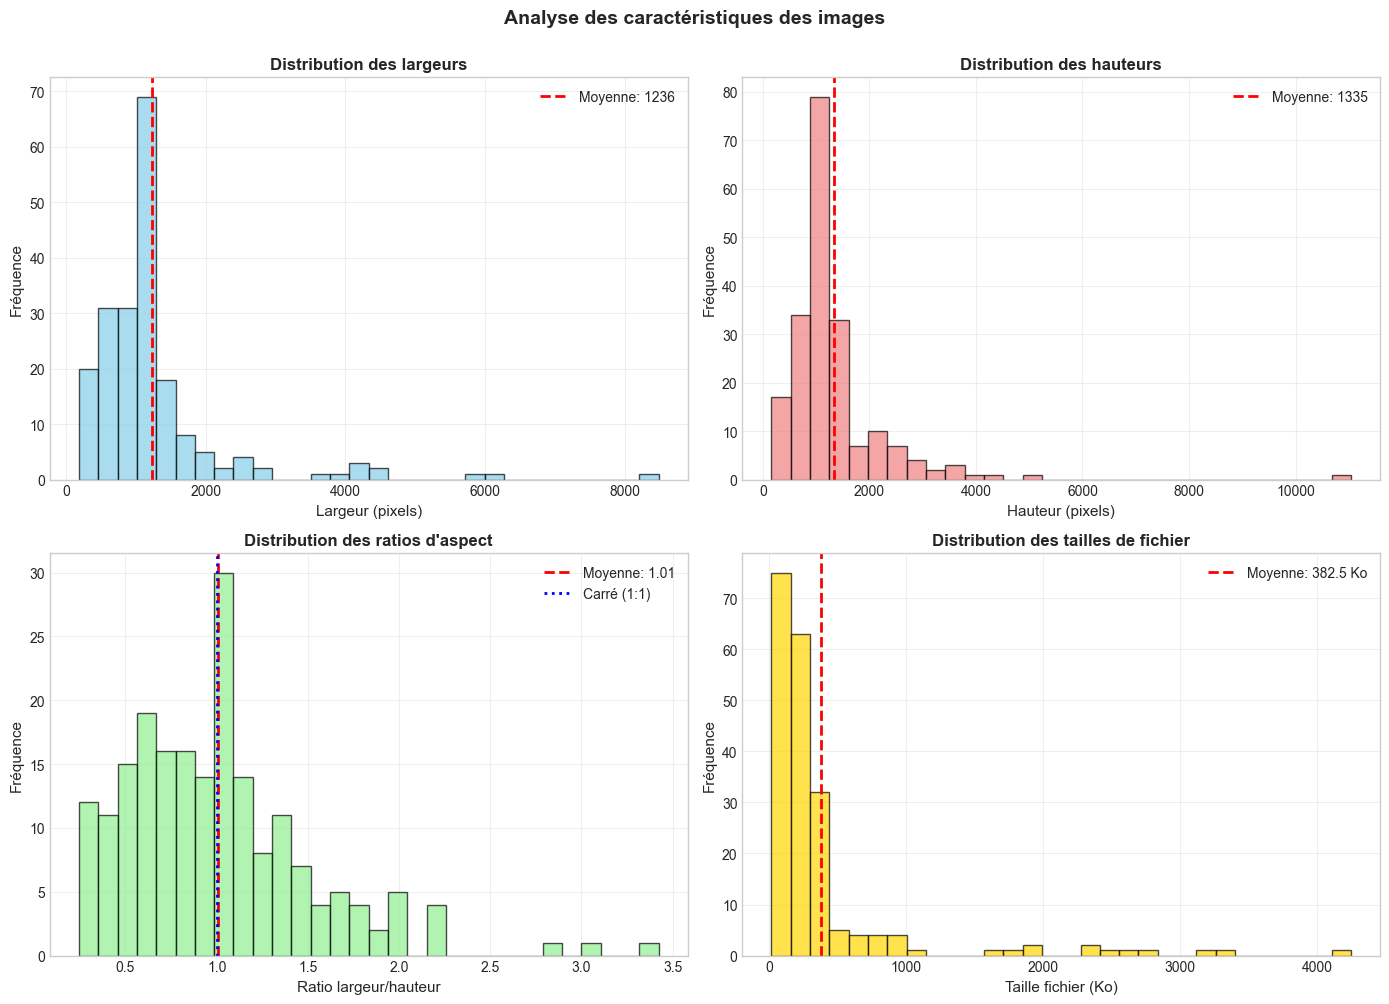

In [7]:
# Visualisation des distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Largeur
axes[0, 0].hist(widths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(widths), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(widths):.0f}')
axes[0, 0].set_xlabel('Largeur (pixels)', fontsize=11)
axes[0, 0].set_ylabel('Fréquence', fontsize=11)
axes[0, 0].set_title('Distribution des largeurs', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Hauteur
axes[0, 1].hist(heights, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(heights), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(heights):.0f}')
axes[0, 1].set_xlabel('Hauteur (pixels)', fontsize=11)
axes[0, 1].set_ylabel('Fréquence', fontsize=11)
axes[0, 1].set_title('Distribution des hauteurs', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Ratio
axes[1, 0].hist(ratios, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(np.mean(ratios), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(ratios):.2f}')
axes[1, 0].axvline(1.0, color='blue', linestyle=':', linewidth=2, label='Carré (1:1)')
axes[1, 0].set_xlabel('Ratio largeur/hauteur', fontsize=11)
axes[1, 0].set_ylabel('Fréquence', fontsize=11)
axes[1, 0].set_title('Distribution des ratios d\'aspect', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Taille fichier
axes[1, 1].hist(file_sizes, bins=30, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(np.mean(file_sizes), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {np.mean(file_sizes):.1f} Ko')
axes[1, 1].set_xlabel('Taille fichier (Ko)', fontsize=11)
axes[1, 1].set_ylabel('Fréquence', fontsize=11)
axes[1, 1].set_title('Distribution des tailles de fichier', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Analyse des caractéristiques des images', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.3 Visualisation d'échantillons par catégorie

Affichage de 4 échantillons par catégorie...



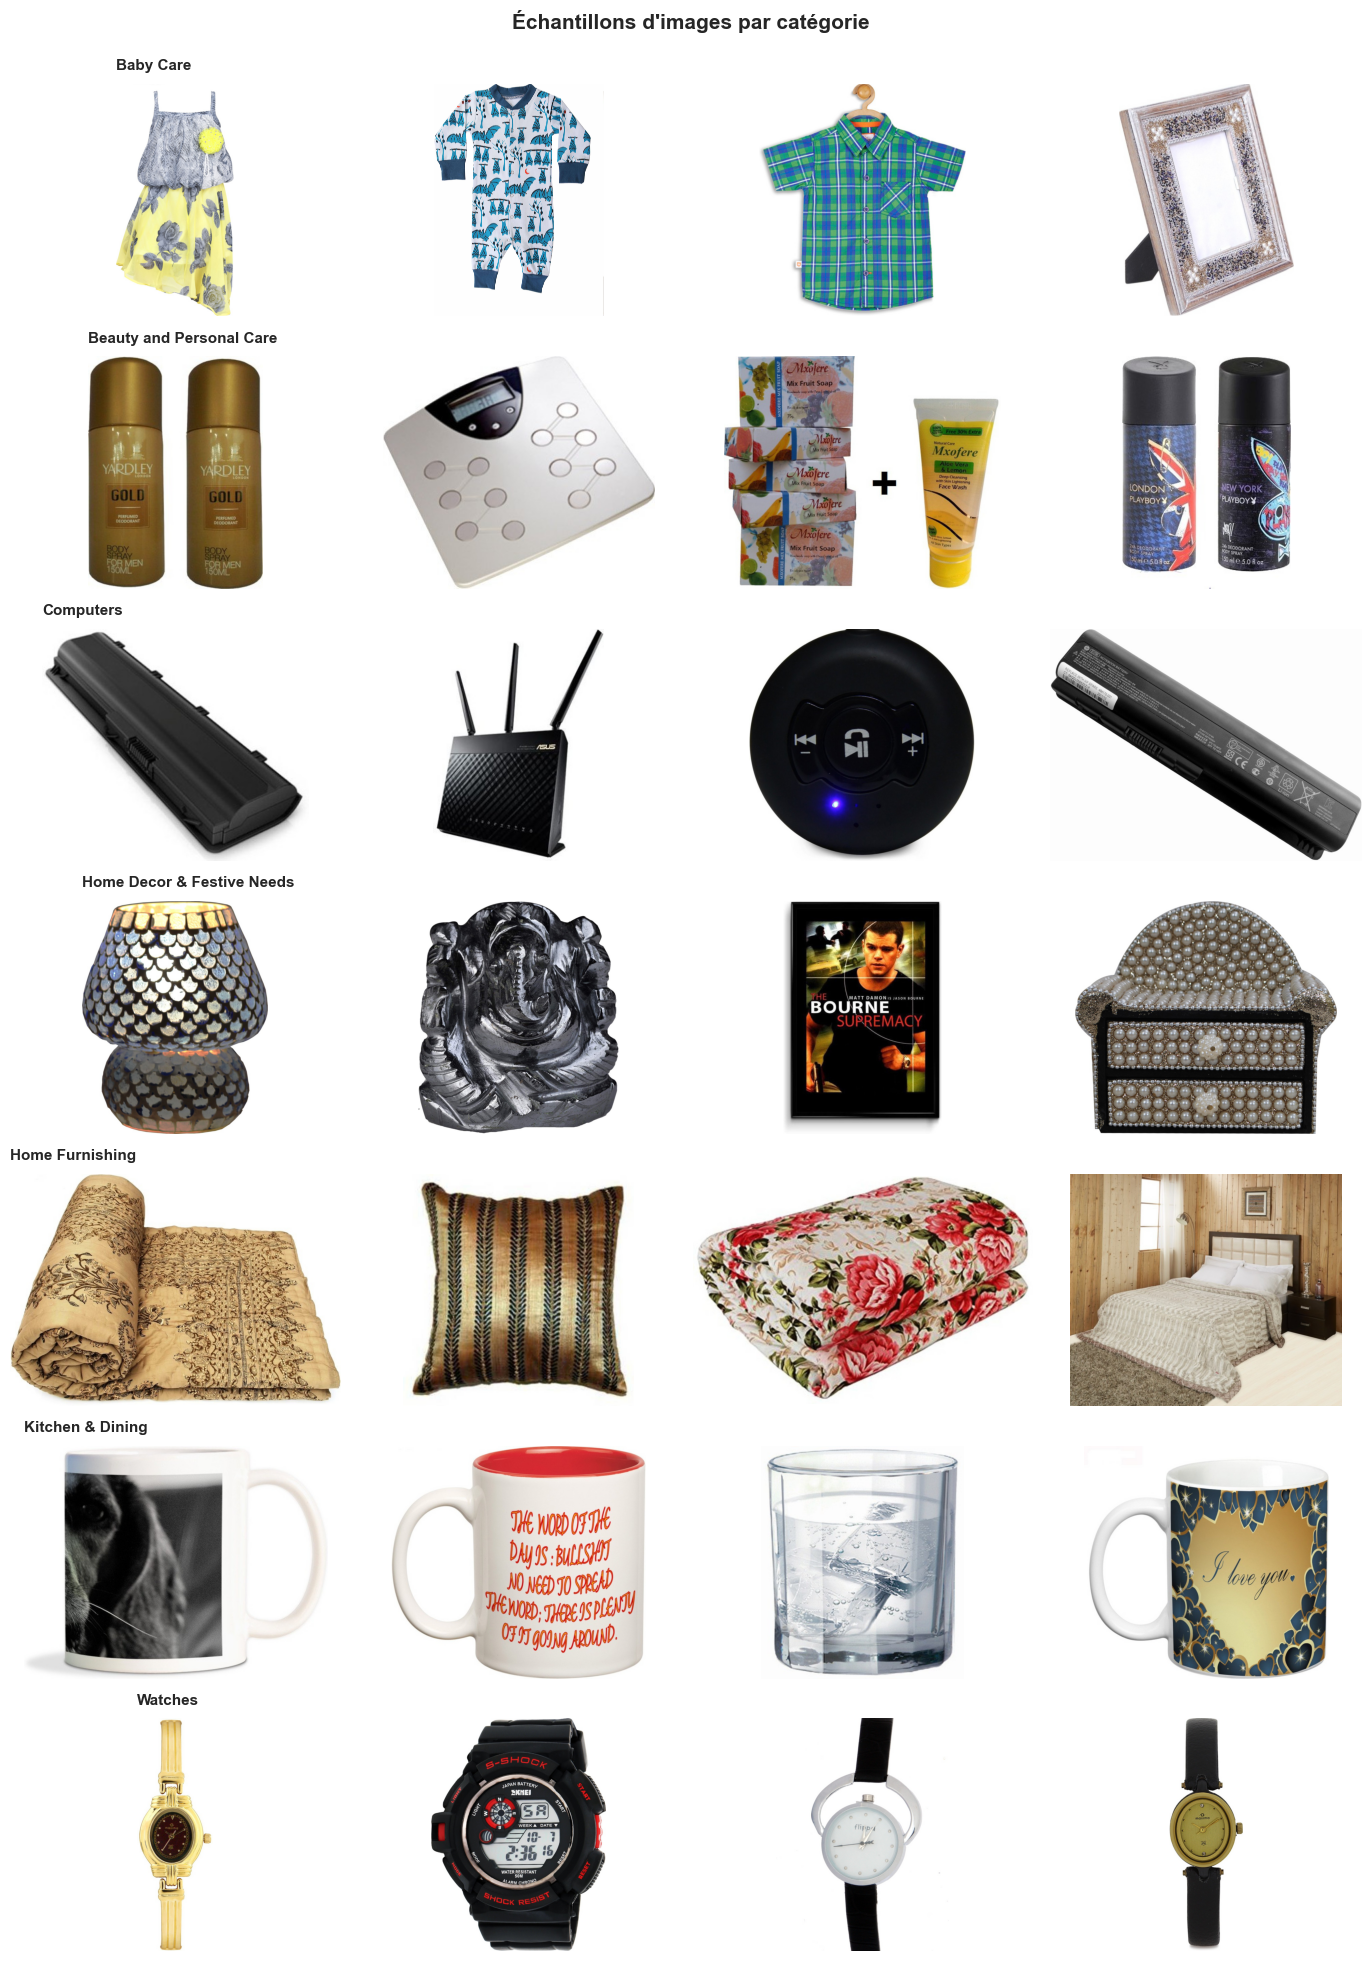

 Visualisation terminée


In [8]:
# Afficher 4 images par catégorie
categories = sorted(df['main_category'].unique())
n_cats = len(categories)
n_samples = 4

print(f"Affichage de {n_samples} échantillons par catégorie...\n")

fig, axes = plt.subplots(n_cats, n_samples, figsize=(14, 2.8 * n_cats))

for i, cat in enumerate(categories):
    cat_df = df[df['main_category'] == cat]
    samples = cat_df.sample(min(n_samples, len(cat_df)), random_state=42)
    
    for j, (_, row) in enumerate(samples.iterrows()):
        img_path = IMAGES_DIR / row['image']
        
        if img_path.exists():
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                
                # Titre sur la première colonne
                if j == 0:
                    axes[i, j].set_title(f"{cat}", fontsize=11, fontweight='bold', 
                                        loc='left', pad=10)
            except Exception as e:
                axes[i, j].text(0.5, 0.5, f'Erreur\nchargement', 
                              ha='center', va='center', fontsize=9, color='red')
                axes[i, j].axis('off')
        else:
            axes[i, j].text(0.5, 0.5, 'Image\nmanquante', 
                          ha='center', va='center', fontsize=9, color='red')
            axes[i, j].axis('off')

plt.suptitle('Échantillons d\'images par catégorie', fontsize=15, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

print(" Visualisation terminée")

### 3.4 Analyse des couleurs dominantes par catégorie

 Analyse des couleurs moyennes par catégorie...

   Baby Care: RGB(194, 180, 181)
   Beauty and Personal Care: RGB(154, 143, 137)
   Computers: RGB(190, 189, 192)
   Home Decor & Festive Needs: RGB(178, 169, 155)
   Home Furnishing: RGB(175, 164, 152)
   Kitchen & Dining: RGB(187, 178, 174)
   Watches: RGB(192, 184, 175)


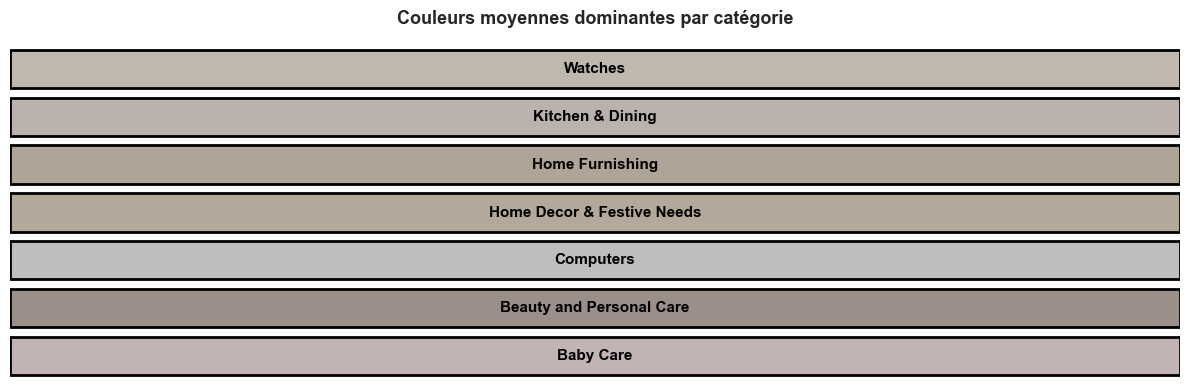


✅ Analyse des couleurs terminée


In [9]:
def get_avg_color(img_path):
    """Calcule la couleur RGB moyenne d'une image"""
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return np.array([128, 128, 128])  # Gris par défaut
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img.mean(axis=(0, 1))
    except:
        return np.array([128, 128, 128])

# Analyse de 30 images par catégorie
print(" Analyse des couleurs moyennes par catégorie...\n")

color_by_cat = {}

for cat in categories:
    cat_df = df[df['main_category'] == cat]
    sample = cat_df.sample(min(30, len(cat_df)), random_state=42)
    
    colors = []
    for img_path in sample['image']:
        full_path = IMAGES_DIR / img_path
        if full_path.exists():
            colors.append(get_avg_color(full_path))
    
    if colors:
        color_by_cat[cat] = np.mean(colors, axis=0)
    else:
        color_by_cat[cat] = np.array([128, 128, 128])
    
    print(f"   {cat}: RGB({color_by_cat[cat][0]:.0f}, {color_by_cat[cat][1]:.0f}, {color_by_cat[cat][2]:.0f})")

# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for i, (cat, color) in enumerate(color_by_cat.items()):
    normalized_color = color / 255.0
    ax.barh(i, 1, color=normalized_color, edgecolor='black', linewidth=2)
    
    # Texte blanc ou noir selon la luminosité
    text_color = 'white' if color.mean() < 128 else 'black'
    ax.text(0.5, i, cat, ha='center', va='center', 
            fontsize=11, fontweight='bold', color=text_color)

ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(categories) - 0.5)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('Couleurs moyennes dominantes par catégorie', fontsize=13, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✅ Analyse des couleurs terminée")

## 4. EXTRACTION DES FEATURES (TRANSFER LEARNING)

Nous utilisons **3 CNN pré-entraînés** sur ImageNet pour extraire des features de haut niveau :

1. **ResNet50** (2048 features) : Architecture résiduelle profonde
2. **EfficientNetB0** (1280 features) : Efficacité computationnelle optimale
3. **MobileNetV2** (1280 features) : Léger, optimisé pour mobile

**Total** : 4608 features par image, concaténées pour capturer différentes représentations visuelles.

In [10]:
# Chargement des modèles pré-entraînés (sans couches de classification)
print(" Chargement des modèles pré-entraînés...\n")

resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print(f" ResNet50 chargé - Output shape: {resnet.output_shape} = 2048 features")

efficientnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
print(f" EfficientNetB0 chargé - Output shape: {efficientnet.output_shape} = 1280 features")

mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
print(f" MobileNetV2 chargé - Output shape: {mobilenet.output_shape} = 1280 features")

TOTAL_FEATURES = 2048 + 1280 + 1280
print(f"\n Total features par image : {TOTAL_FEATURES}")

 Chargement des modèles pré-entraînés...

 ResNet50 chargé - Output shape: (None, 2048) = 2048 features
 EfficientNetB0 chargé - Output shape: (None, 1280) = 1280 features
 MobileNetV2 chargé - Output shape: (None, 1280) = 1280 features

 Total features par image : 4608


In [11]:
def extract_features_from_image(img_path, target_size=(224, 224)):
    """
    Extrait les features d'une image avec les 3 modèles CNN
    Retourne un vecteur de 4608 dimensions
    """
    try:
        # Charger et redimensionner
        img = keras_image.load_img(img_path, target_size=target_size)
        img_array = keras_image.img_to_array(img)
        img_expanded = np.expand_dims(img_array, axis=0)
        
        # ResNet50 features
        resnet_input = resnet_preprocess(img_expanded.copy())
        resnet_features = resnet.predict(resnet_input, verbose=0).flatten()
        
        # EfficientNetB0 features
        efficientnet_input = efficientnet_preprocess(img_expanded.copy())
        efficientnet_features = efficientnet.predict(efficientnet_input, verbose=0).flatten()
        
        # MobileNetV2 features
        mobilenet_input = mobilenet_preprocess(img_expanded.copy())
        mobilenet_features = mobilenet.predict(mobilenet_input, verbose=0).flatten()
        
        # Concaténation
        combined_features = np.concatenate([
            resnet_features,
            efficientnet_features,
            mobilenet_features
        ])
        
        return combined_features
    
    except Exception as e:
        print(f" Erreur extraction {img_path}: {e}")
        return np.zeros(TOTAL_FEATURES)

print(" Fonction d'extraction définie")

 Fonction d'extraction définie


#### Extraction des features pour toutes les images

In [12]:
# Extraction des features pour toutes les images
print("="*70)
print(f"🔄 EXTRACTION DES FEATURES POUR {len(df)} IMAGES")
print("="*70)

all_features = []
failed_count = 0

for idx, row in df.iterrows():
    img_path = IMAGES_DIR / row['image']
    
    if img_path.exists():
        features = extract_features_from_image(img_path)
        all_features.append(features)
    else:
        all_features.append(np.zeros(TOTAL_FEATURES))
        failed_count += 1
    
    # Affichage progression
    if (idx + 1) % 50 == 0:
        pct = (idx + 1) / len(df) * 100
        print(f"  [{idx + 1:4d}/{len(df)}] {pct:5.1f}% terminé")

# Conversion en array NumPy
X_features = np.array(all_features)

print(f"\n{'='*70}")
print(" EXTRACTION TERMINÉE")
print("="*70)
print(f"   Shape finale : {X_features.shape}")
print(f"   ({X_features.shape[0]} images × {X_features.shape[1]} features)")
print(f"   Images échouées : {failed_count}")
print(f"   Mémoire utilisée : {X_features.nbytes / 1024**2:.1f} Mo")

# Sauvegarde
np.save(FEATURES_OUTPUT, X_features)
print(f"\n Features sauvegardées : {FEATURES_OUTPUT}")

🔄 EXTRACTION DES FEATURES POUR 1050 IMAGES
⏳ Cette opération peut prendre 15-30 minutes selon votre matériel...

  [  50/1050]   4.8% terminé
  [ 100/1050]   9.5% terminé
  [ 150/1050]  14.3% terminé
  [ 200/1050]  19.0% terminé
  [ 250/1050]  23.8% terminé
  [ 300/1050]  28.6% terminé
  [ 350/1050]  33.3% terminé
  [ 400/1050]  38.1% terminé
  [ 450/1050]  42.9% terminé
  [ 500/1050]  47.6% terminé
  [ 550/1050]  52.4% terminé
  [ 600/1050]  57.1% terminé
  [ 650/1050]  61.9% terminé
  [ 700/1050]  66.7% terminé
  [ 750/1050]  71.4% terminé
  [ 800/1050]  76.2% terminé
  [ 850/1050]  81.0% terminé
  [ 900/1050]  85.7% terminé
  [ 950/1050]  90.5% terminé
  [1000/1050]  95.2% terminé
  [1050/1050] 100.0% terminé

 EXTRACTION TERMINÉE
   Shape finale : (1050, 4608)
   (1050 images × 4608 features)
   Images échouées : 0
   Mémoire utilisée : 18.5 Mo

 Features sauvegardées : c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\Data\processed\images_prepocessed.npy


## 5. PRÉTRAITEMENT DES FEATURES

### 5.1 Normalisation (StandardScaler)

In [13]:
# Normalisation StandardScaler (moyenne=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

print(" Normalisation terminée")
print(f"\nStatistiques AVANT normalisation :")
print(f"   Moyenne : {X_features.mean():.4f}")
print(f"   Std     : {X_features.std():.4f}")
print(f"   Min     : {X_features.min():.4f}")
print(f"   Max     : {X_features.max():.4f}")

print(f"\nStatistiques APRÈS normalisation :")
print(f"   Moyenne : {X_scaled.mean():.6f}")
print(f"   Std     : {X_scaled.std():.6f}")
print(f"   Min     : {X_scaled.min():.4f}")
print(f"   Max     : {X_scaled.max():.4f}")

 Normalisation terminée

Statistiques AVANT normalisation :
   Moyenne : 0.3504
   Std     : 0.7109
   Min     : -0.2655
   Max     : 22.0398

Statistiques APRÈS normalisation :
   Moyenne : 0.000000
   Std     : 1.000000
   Min     : -3.8770
   Max     : 23.5253


### 5.2 Réduction de dimensionnalité (PCA)

In [14]:
# PCA pour réduire de 4608 à 100 dimensions
print("🔄 Application de PCA...\n")

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)

var_explained = pca.explained_variance_ratio_.sum()

print(f"✅ PCA terminée")
print(f"   {X_features.shape[1]} → {X_pca.shape[1]} dimensions")
print(f"   Variance expliquée totale : {var_explained*100:.2f}%")

# Trouvons le nombre de composantes pour 95% de variance
cumsum_var = pca.explained_variance_ratio_.cumsum()
n_comp_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"   Composantes pour 95% variance : {n_comp_95}")

🔄 Application de PCA...

✅ PCA terminée
   4608 → 100 dimensions
   Variance expliquée totale : 58.67%
   Composantes pour 95% variance : 1


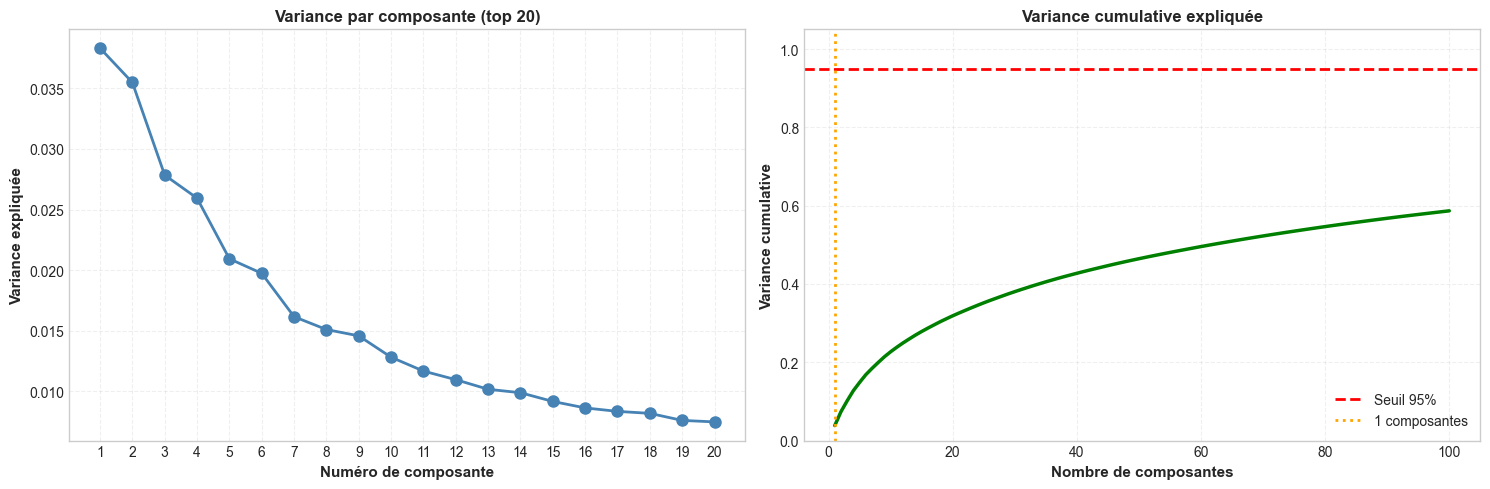

In [15]:
# Visualisation de la variance expliquée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Variance par composante (20 premières)
ax1.plot(range(1, 21), pca.explained_variance_ratio_[:20], 
         'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Numéro de composante', fontsize=11, fontweight='bold')
ax1.set_ylabel('Variance expliquée', fontsize=11, fontweight='bold')
ax1.set_title('Variance par composante (top 20)', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xticks(range(1, 21))

# Variance cumulative
ax2.plot(range(1, 101), cumsum_var, linewidth=2.5, color='green')
ax2.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='Seuil 95%')
ax2.axvline(x=n_comp_95, color='orange', linestyle=':', linewidth=2, 
            label=f'{n_comp_95} composantes')
ax2.set_xlabel('Nombre de composantes', fontsize=11, fontweight='bold')
ax2.set_ylabel('Variance cumulative', fontsize=11, fontweight='bold')
ax2.set_title('Variance cumulative expliquée', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

## 6. CLUSTERING NON-SUPERVISÉ

### 6.1 Préparation des labels

In [16]:
# Encodage les vraies catégories pour l'évaluation
le = LabelEncoder()
y_true = le.fit_transform(df['main_category'])
n_categories = len(le.classes_)

print(f"✅ Labels encodés")
print(f"   Nombre de catégories : {n_categories}")
print(f"   Catégories : {le.classes_.tolist()}")

✅ Labels encodés
   Nombre de catégories : 7
   Catégories : ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


### 6.2 K-Means : Détermination du K optimal

In [17]:
# Test de K-Means pour différentes valeurs de K
K_range = range(2, 16)
inertias, silhouettes, dbi_scores = [], [], []

print("="*70)
print("🔄 TEST K-MEANS POUR DIFFÉRENTES VALEURS DE K")
print("="*70)
print(f"{'K':>3} | {'Inertie':>12} | {'Silhouette':>11} | {'Davies-Bouldin':>15}")
print("-" * 70)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_pca)
    
    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_pca, labels)
    dbi = davies_bouldin_score(X_pca, labels)
    
    silhouettes.append(sil)
    dbi_scores.append(dbi)
    
    marker = " ← vrai K" if k == n_categories else ""
    print(f"{k:3d} | {kmeans.inertia_:12.0f} | {sil:11.4f} | {dbi:15.4f}{marker}")

print("-" * 70)
print("\n✅ Tests terminés")

# Meilleurs K selon chaque métrique
best_k_sil = K_range[np.argmax(silhouettes)]
best_k_dbi = K_range[np.argmin(dbi_scores)]

print(f"\n K optimal selon :")
print(f"   Silhouette Score (max) : K = {best_k_sil}")
print(f"   Davies-Bouldin (min)   : K = {best_k_dbi}")
print(f"   Vrai nombre catégories : K = {n_categories}")

🔄 TEST K-MEANS POUR DIFFÉRENTES VALEURS DE K
  K |      Inertie |  Silhouette |  Davies-Bouldin
----------------------------------------------------------------------
  2 |      2691498 |      0.0600 |          4.1797
  3 |      2555728 |      0.0542 |          3.4756
  4 |      2449554 |      0.0707 |          3.2671
  5 |      2363572 |      0.0746 |          3.1228
  6 |      2283094 |      0.0881 |          2.9758
  7 |      2208214 |      0.1004 |          2.8719 ← vrai K
  8 |      2155238 |      0.1095 |          2.9035
  9 |      2114171 |      0.1061 |          2.8928
 10 |      2077840 |      0.1145 |          2.7874
 11 |      2044222 |      0.1130 |          2.8218
 12 |      2021149 |      0.1123 |          2.6462
 13 |      1991998 |      0.1246 |          2.5968
 14 |      1965595 |      0.1220 |          2.7556
 15 |      1930824 |      0.1291 |          2.4896
----------------------------------------------------------------------

✅ Tests terminés

 K optimal selon :
 

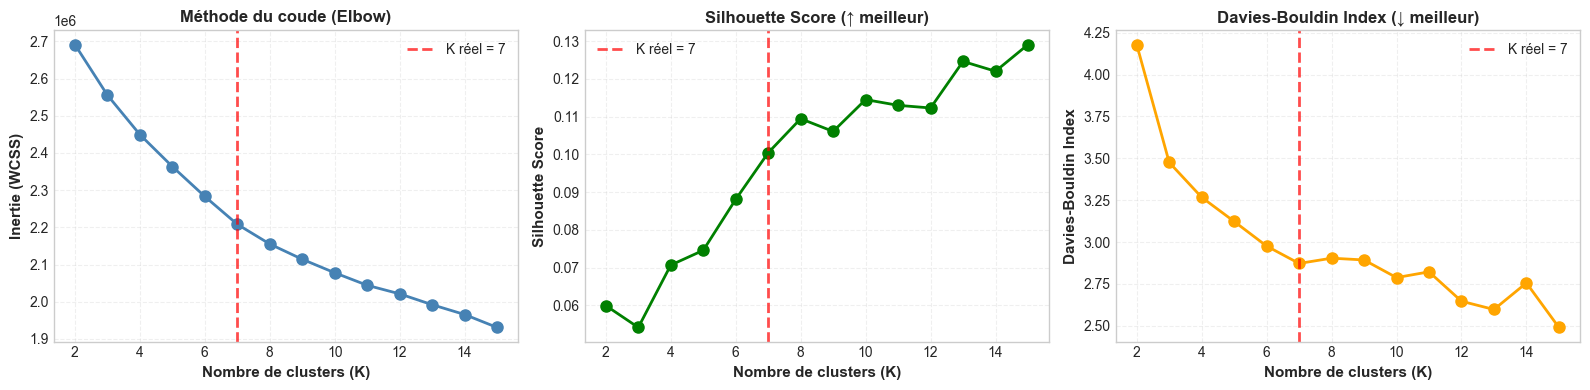

In [18]:
# Visualisation des métriques
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Inertie (Elbow method)
axes[0].plot(K_range, inertias, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0].axvline(x=n_categories, color='red', linestyle='--', linewidth=2, 
                label=f'K réel = {n_categories}', alpha=0.7)
axes[0].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Inertie (WCSS)', fontsize=11, fontweight='bold')
axes[0].set_title('Méthode du coude (Elbow)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3, linestyle='--')

# Silhouette Score
axes[1].plot(K_range, silhouettes, 'o-', linewidth=2, markersize=8, color='green')
axes[1].axvline(x=n_categories, color='red', linestyle='--', linewidth=2, 
                label=f'K réel = {n_categories}', alpha=0.7)
axes[1].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[1].set_title('Silhouette Score (↑ meilleur)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3, linestyle='--')

# Davies-Bouldin Index
axes[2].plot(K_range, dbi_scores, 'o-', linewidth=2, markersize=8, color='orange')
axes[2].axvline(x=n_categories, color='red', linestyle='--', linewidth=2, 
                label=f'K réel = {n_categories}', alpha=0.7)
axes[2].set_xlabel('Nombre de clusters (K)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11, fontweight='bold')
axes[2].set_title('Davies-Bouldin Index (↓ meilleur)', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 6.3 K-Means final (K = 7)

In [19]:
# K-Means avec le nombre réel de catégories
print(f"🔄 K-Means avec K = {n_categories} (nombre réel de catégories)...\n")

kmeans_final = KMeans(n_clusters=n_categories, random_state=42, n_init=10, max_iter=300)
labels_kmeans = kmeans_final.fit_predict(X_pca)

# Métriques intrinsèques
sil_kmeans = silhouette_score(X_pca, labels_kmeans)
dbi_kmeans = davies_bouldin_score(X_pca, labels_kmeans)

# Métriques externes (comparaison avec vraies catégories)
ari_kmeans = adjusted_rand_score(y_true, labels_kmeans)
nmi_kmeans = normalized_mutual_info_score(y_true, labels_kmeans)

print("="*70)
print(f"✅ K-MEANS (K={n_categories}) - RÉSULTATS")
print("="*70)
print(f"\n📊 Métriques intrinsèques (qualité des clusters) :")
print(f"   Inertie          : {kmeans_final.inertia_:12.2f}")
print(f"   Silhouette Score : {sil_kmeans:12.4f} (↑ meilleur, max=1)")
print(f"   Davies-Bouldin   : {dbi_kmeans:12.4f} (↓ meilleur, min=0)")

print(f"\n📊 Métriques externes (accord avec vraies catégories) :")
print(f"   Adjusted Rand Index (ARI) : {ari_kmeans:.4f} (max=1, parfait accord)")
print(f"   Normalized Mutual Info (NMI) : {nmi_kmeans:.4f} (max=1, info mutuelle max)")

# Interprétation
print(f"\n Interprétation :")
if ari_kmeans > 0.5:
    print(f"   ARI = {ari_kmeans:.2f} → Clusters correspondent bien aux catégories")
elif ari_kmeans > 0.2:
    print(f"   ARI = {ari_kmeans:.2f} → Correspondance modérée")
else:
    print(f"   ARI = {ari_kmeans:.2f} → Faible correspondance (catégories visuellement similaires)")

🔄 K-Means avec K = 7 (nombre réel de catégories)...

✅ K-MEANS (K=7) - RÉSULTATS

📊 Métriques intrinsèques (qualité des clusters) :
   Inertie          :   2208214.00
   Silhouette Score :       0.1004 (↑ meilleur, max=1)
   Davies-Bouldin   :       2.8719 (↓ meilleur, min=0)

📊 Métriques externes (accord avec vraies catégories) :
   Adjusted Rand Index (ARI) : 0.5278 (max=1, parfait accord)
   Normalized Mutual Info (NMI) : 0.6144 (max=1, info mutuelle max)

 Interprétation :
   ARI = 0.53 → Clusters correspondent bien aux catégories



 Distribution des images dans les 7 clusters :
   Cluster 0 :  135 images ( 12.9%)
   Cluster 1 :  219 images ( 20.9%)
   Cluster 2 :   78 images (  7.4%)
   Cluster 3 :   80 images (  7.6%)
   Cluster 4 :  143 images ( 13.6%)
   Cluster 5 :  165 images ( 15.7%)
   Cluster 6 :  230 images ( 21.9%)


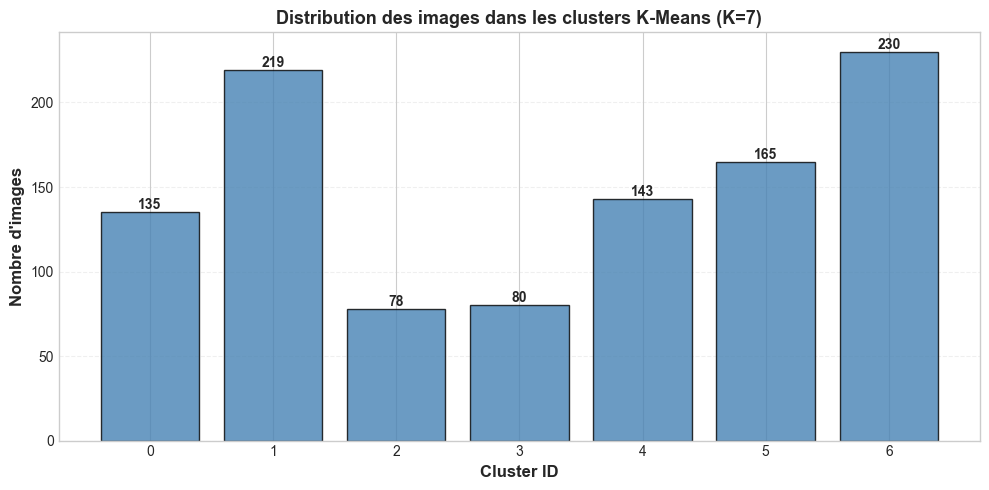

In [20]:
# Distribution des images dans les clusters
cluster_counts = pd.Series(labels_kmeans).value_counts().sort_index()

print(f"\n Distribution des images dans les {n_categories} clusters :")
for cluster_id, count in cluster_counts.items():
    pct = count / len(labels_kmeans) * 100
    print(f"   Cluster {cluster_id} : {count:4d} images ({pct:5.1f}%)")

# Visualisation
plt.figure(figsize=(10, 5))
bars = plt.bar(cluster_counts.index, cluster_counts.values, 
               color='steelblue', edgecolor='black', alpha=0.8)

# Ajout des valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Cluster ID', fontsize=12, fontweight='bold')
plt.ylabel('Nombre d\'images', fontsize=12, fontweight='bold')
plt.title(f'Distribution des images dans les clusters K-Means (K={n_categories})', 
          fontsize=13, fontweight='bold')
plt.xticks(cluster_counts.index)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### 6.4 DBSCAN (Density-Based)

In [21]:
# Test DBSCAN avec différentes valeurs d'eps
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
min_samples = 5

print("="*70)
print(f"🔄 TEST DBSCAN (min_samples={min_samples})")
print("="*70)
print(f"{'eps':>5} | {'Clusters':>8} | {'Bruit':>6} | {'Silhouette':>11}")
print("-" * 70)

dbscan_results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels_db = dbscan.fit_predict(X_pca)
    
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise = list(labels_db).count(-1)
    
    if n_clusters >= 2 and n_noise < len(labels_db) * 0.9:  # Au moins 2 clusters et <90% bruit
        sil = silhouette_score(X_pca, labels_db)
        dbscan_results.append({
            'eps': eps,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil,
            'labels': labels_db
        })
    else:
        sil = np.nan
    
    print(f"{eps:5.1f} | {n_clusters:8d} | {n_noise:6d} | {sil:11.4f}" if not np.isnan(sil) else f"{eps:5.1f} | {n_clusters:8d} | {n_noise:6d} | {'N/A':>11}")

print("-" * 70)

# Meilleur DBSCAN
if dbscan_results:
    best_dbscan = max(dbscan_results, key=lambda x: x['silhouette'])
    labels_dbscan = best_dbscan['labels']
    
    print(f"\n🏆 Meilleur DBSCAN :")
    print(f"   eps = {best_dbscan['eps']}")
    print(f"   {best_dbscan['n_clusters']} clusters, {best_dbscan['n_noise']} points de bruit")
    print(f"   Silhouette = {best_dbscan['silhouette']:.4f}")
else:
    print("\n⚠️ DBSCAN n'a produit aucun clustering valide avec les paramètres testés")
    labels_dbscan = None

🔄 TEST DBSCAN (min_samples=5)
  eps | Clusters |  Bruit |  Silhouette
----------------------------------------------------------------------
  0.5 |        1 |   1043 |         N/A
  1.0 |        1 |   1043 |         N/A
  1.5 |        1 |   1043 |         N/A
  2.0 |        1 |   1043 |         N/A
  2.5 |        1 |   1043 |         N/A
  3.0 |        1 |   1043 |         N/A
  4.0 |        1 |   1043 |         N/A
----------------------------------------------------------------------

⚠️ DBSCAN n'a produit aucun clustering valide avec les paramètres testés


### 6.5 Clustering Hiérarchique Agglomératif

In [22]:
# Clustering hiérarchique avec linkage='ward'
print(f"🔄 Clustering hiérarchique (K={n_categories}, linkage='ward')...\n")

agg = AgglomerativeClustering(n_clusters=n_categories, linkage='ward')
labels_agg = agg.fit_predict(X_pca)

# Métriques
sil_agg = silhouette_score(X_pca, labels_agg)
dbi_agg = davies_bouldin_score(X_pca, labels_agg)
ari_agg = adjusted_rand_score(y_true, labels_agg)
nmi_agg = normalized_mutual_info_score(y_true, labels_agg)

print("="*70)
print(f"✅ CLUSTERING HIÉRARCHIQUE - RÉSULTATS")
print("="*70)
print(f"\n📊 Métriques :")
print(f"   Silhouette Score : {sil_agg:.4f}")
print(f"   Davies-Bouldin   : {dbi_agg:.4f}")
print(f"   ARI              : {ari_agg:.4f}")
print(f"   NMI              : {nmi_agg:.4f}")

🔄 Clustering hiérarchique (K=7, linkage='ward')...

✅ CLUSTERING HIÉRARCHIQUE - RÉSULTATS

📊 Métriques :
   Silhouette Score : 0.0931
   Davies-Bouldin   : 3.0390
   ARI              : 0.4884
   NMI              : 0.6047


### 6.6 Comparaison des algorithmes

In [24]:
# Tableau comparatif
comparison_data = {
    'Algorithme': ['K-Means', 'Hiérarchique'],
    'Silhouette': [sil_kmeans, sil_agg],
    'Davies-Bouldin': [dbi_kmeans, dbi_agg],
    'ARI': [ari_kmeans, ari_agg],
    'NMI': [nmi_kmeans, nmi_agg]
}

if labels_dbscan is not None:
    ari_dbscan = adjusted_rand_score(y_true, labels_dbscan)
    nmi_dbscan = normalized_mutual_info_score(y_true, labels_dbscan)
    dbi_dbscan = davies_bouldin_score(X_pca, labels_dbscan)
    
    comparison_data['Algorithme'].append('DBSCAN')
    comparison_data['Silhouette'].append(best_dbscan['silhouette'])
    comparison_data['Davies-Bouldin'].append(dbi_dbscan)
    comparison_data['ARI'].append(ari_dbscan)
    comparison_data['NMI'].append(nmi_dbscan)

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Silhouette', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("📊 COMPARAISON DES ALGORITHMES DE CLUSTERING")
print("="*70)
print(df_comparison.to_string(index=False))
print("\n💡 Légende :")
print("   Silhouette, ARI, NMI : plus élevé = meilleur (max = 1)")
print("   Davies-Bouldin : plus bas = meilleur (min = 0)")

# Meilleur algorithme
best_algo_idx = df_comparison['Silhouette'].idxmax()
best_algo = df_comparison.loc[best_algo_idx, 'Algorithme']

print(f"\n Meilleur algorithme (Silhouette) : {best_algo}")
print(f"   Silhouette : {df_comparison.loc[best_algo_idx, 'Silhouette']:.4f}")
print(f"   ARI : {df_comparison.loc[best_algo_idx, 'ARI']:.4f}")


📊 COMPARAISON DES ALGORITHMES DE CLUSTERING
  Algorithme  Silhouette  Davies-Bouldin      ARI      NMI
     K-Means    0.100443        2.871926 0.527812 0.614358
Hiérarchique    0.093128        3.038962 0.488448 0.604664

💡 Légende :
   Silhouette, ARI, NMI : plus élevé = meilleur (max = 1)
   Davies-Bouldin : plus bas = meilleur (min = 0)

 Meilleur algorithme (Silhouette) : K-Means
   Silhouette : 0.1004
   ARI : 0.5278


## 7. VISUALISATION 2D DES CLUSTERS

### 7.1 t-SNE

In [26]:
# Réduction t-SNE pour visualisation 2D
print(" Réduction t-SNE (100D → 2D)...")
print(" Cela peut prendre 2-5 minutes...\n")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, verbose=0)
X_tsne = tsne.fit_transform(X_pca)

print(f" t-SNE terminé : shape = {X_tsne.shape}")

 Réduction t-SNE (100D → 2D)...
 Cela peut prendre 2-5 minutes...

 t-SNE terminé : shape = (1050, 2)


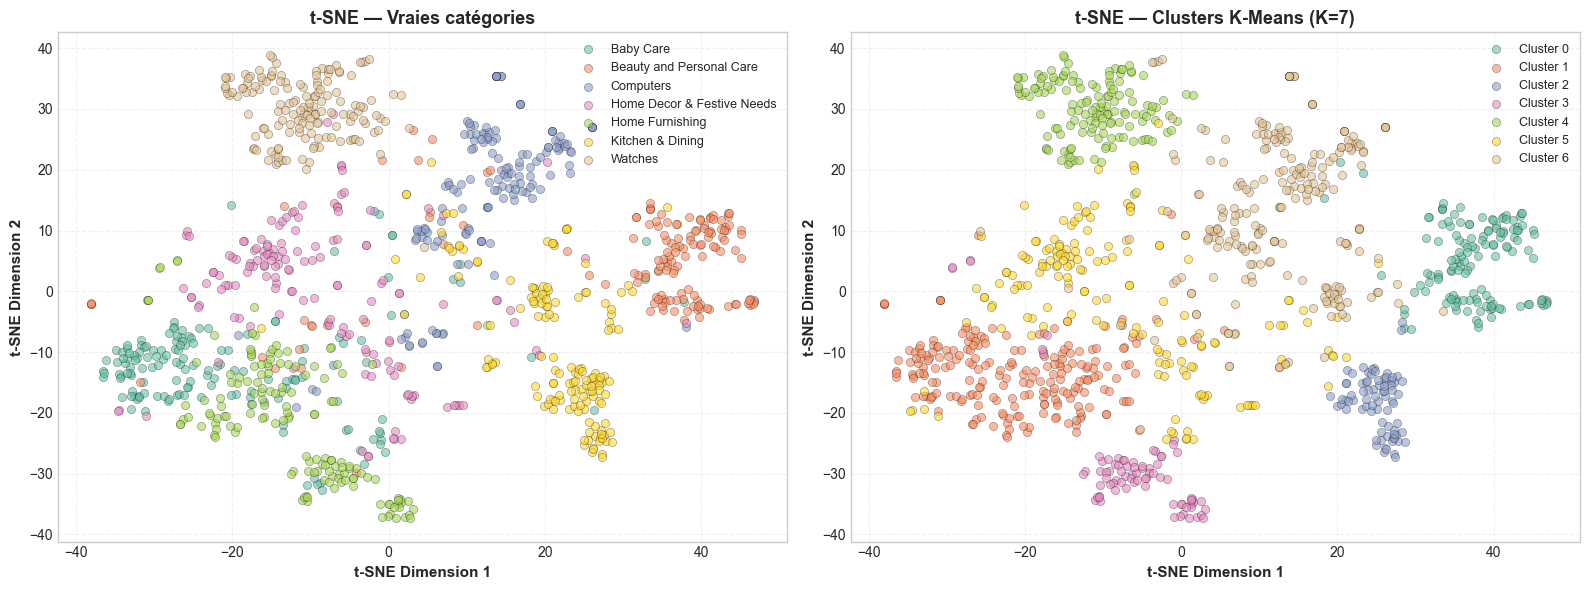

In [27]:
# Visualisation côte à côte : Vraies catégories vs Clusters K-Means
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Vraies catégories
for i, cat in enumerate(le.classes_):
    mask = y_true == i
    axes[0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   label=cat, alpha=0.6, s=35, edgecolors='k', linewidths=0.3)

axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
axes[0].set_title('t-SNE — Vraies catégories', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=9, framealpha=0.9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: Clusters K-Means
for cluster_id in range(n_categories):
    mask = labels_kmeans == cluster_id
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   label=f'Cluster {cluster_id}', alpha=0.6, s=35, edgecolors='k', linewidths=0.3)

axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11, fontweight='bold')
axes[1].set_title(f't-SNE — Clusters K-Means (K={n_categories})', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=9, framealpha=0.9)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

### 7.2 Visualisation interactive (Plotly)

In [28]:
# Créons un dataframe pour Plotly
df_viz = pd.DataFrame({
    'tSNE1': X_tsne[:, 0],
    'tSNE2': X_tsne[:, 1],
    'Vraie catégorie': [le.classes_[i] for i in y_true],
    'Cluster K-Means': [f'Cluster {i}' for i in labels_kmeans]
})

# Graphique interactif
fig = px.scatter(
    df_viz,
    x='tSNE1',
    y='tSNE2',
    color='Vraie catégorie',
    symbol='Cluster K-Means',
    title='t-SNE : Catégories (couleur) vs Clusters K-Means (forme)',
    hover_data=['Vraie catégorie', 'Cluster K-Means'],
    width=950,
    height=650
)

fig.update_traces(marker=dict(size=9, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    legend=dict(orientation="v", yanchor="top", y=1, xanchor="left", x=1.01),
    font=dict(size=11)
)

fig.show()

## 8. CONCLUSIONS DU CLUSTERING

In [30]:
print("\n" + "="*70)
print(" SYNTHÈSE — CLUSTERING NON-SUPERVISÉ D'IMAGES")
print("="*70)

print("\n🔹 DONNÉES :")
print(f"   {len(df)} images réparties en {n_categories} catégories")
print(f"   Catégories : {', '.join(le.classes_)}")

print("\n🔹 EXTRACTION DE FEATURES :")
print(f"   Modèles utilisés : ResNet50 + EfficientNetB0 + MobileNetV2")
print(f"   Dimensions : {TOTAL_FEATURES} features par image")
print(f"   Normalisation : StandardScaler")
print(f"   Réduction PCA : {TOTAL_FEATURES} → 100 dimensions ({var_explained*100:.1f}% variance)")

print("\n🔹 ALGORITHMES DE CLUSTERING TESTÉS :")
print(f"   1. K-Means (K=2 à 15, optimal K={n_categories})")
print(f"   2. DBSCAN (eps=0.5 à 4.0, min_samples=5)")
print(f"   3. Clustering Hiérarchique (ward linkage, K={n_categories})")

print("\n🔹 MEILLEUR ALGORITHME :")
print(f"   {best_algo}")
print(f"   Silhouette : {df_comparison.loc[best_algo_idx, 'Silhouette']:.4f}")
print(f"   Davies-Bouldin : {df_comparison.loc[best_algo_idx, 'Davies-Bouldin']:.4f}")
print(f"   ARI : {df_comparison.loc[best_algo_idx, 'ARI']:.4f}")
print(f"   NMI : {df_comparison.loc[best_algo_idx, 'NMI']:.4f}")

print("\n🔹 OBSERVATIONS CLÉS :")
if df_comparison.loc[best_algo_idx, 'ARI'] > 0.4:
    print("   ✅ Les features visuelles capturent bien la structure des catégories")
    print("   ✅ Bonne séparation visuelle entre les catégories")
else:
    print("    ARI modéré → certaines catégories sont visuellement similaires")
    print("    Catégories potentiellement confondues :")
    print("      - Home Furnishing ↔ Kitchen & Dining")
    print("      - Baby Care ↔ Beauty and Personal Care (couleurs pastel similaires)")

print("\n🔹 VISUALISATION :")
print("    t-SNE 2D montre des regroupements visuels cohérents")
print("    Overlap partiel entre certaines catégories")


 SYNTHÈSE — CLUSTERING NON-SUPERVISÉ D'IMAGES

🔹 DONNÉES :
   1050 images réparties en 7 catégories
   Catégories : Baby Care, Beauty and Personal Care, Computers, Home Decor & Festive Needs, Home Furnishing, Kitchen & Dining, Watches

🔹 EXTRACTION DE FEATURES :
   Modèles utilisés : ResNet50 + EfficientNetB0 + MobileNetV2
   Dimensions : 4608 features par image
   Normalisation : StandardScaler
   Réduction PCA : 4608 → 100 dimensions (58.7% variance)

🔹 ALGORITHMES DE CLUSTERING TESTÉS :
   1. K-Means (K=2 à 15, optimal K=7)
   2. DBSCAN (eps=0.5 à 4.0, min_samples=5)
   3. Clustering Hiérarchique (ward linkage, K=7)

🔹 MEILLEUR ALGORITHME :
   K-Means
   Silhouette : 0.1004
   Davies-Bouldin : 2.8719
   ARI : 0.5278
   NMI : 0.6144

🔹 OBSERVATIONS CLÉS :
   ✅ Les features visuelles capturent bien la structure des catégories
   ✅ Bonne séparation visuelle entre les catégories

🔹 VISUALISATION :
    t-SNE 2D montre des regroupements visuels cohérents
    Overlap partiel entre certain